In [1]:
import numpy as np, pandas as pd
import sympy as sym
from sympy import symbols, Matrix, solve, simplify
import math

In [2]:
from db_queries import get_outputs as go, get_ids
from vivarium import Artifact
!whoami
!date

ndbs
Fri Oct  1 13:25:17 PDT 2021


## INITIALIZE VARS

In [3]:
## SOLVE EQNS
s4v, i3v, c4d = symbols('s4v i3v c4d')
r4v, s3v, i2v, c3d = symbols('r4v s3v i2v c3d')
r3v, s2v, i1v, c2d = symbols('r3v s2v i1v c2d')
t1v_sam, r2v_ux, s1v, c1d = symbols('t1v_sam r2v_ux s1v c1d')

s4d, i3d, c4v = symbols('s4d i3d c4v')
r4d, s3d, i2d, c3v = symbols('r4d s3d i2d c3v')
r3d, s2d, i1d, c2v = symbols('r3d s2d i1d c2v')
t1d_sam, r2d_ux, s1d, c1v = symbols('t1d_sam r2d_ux s1d c1v') 

p4v, p3v, p2v, p1v, p4d, p3d, p2d, p1d = symbols('p4v p3v p2v p1v p4d p3d p2d p1d') 
#need to calculate age/sex specific distribution
#pay attention to the age groups (2019 dd prevalence and 2020 wasting exposure)

#acmr = sym.Symbol('acmr')

#dur_cat1, dur_cat2, dur_cat3, dur_cat4 = symbols('dur_cat1 dur_cat2 dur_cat3 dur_cat4')

## SETTINGS

In [4]:
age_group = 5 #1 to 4 yrs
#sex = 2 #female

In [7]:
# these are ordered such that first n (n=9 for now) are the vars we want sympy to solve in terms of the remaining vars

# unknowns = [s1,s2,s3,s4,t1,r2,r3,r4,i1,i2,i3,d1,d2,d3,d4,f1,f2,f3,f4]
# unknowns = [i2,s1,s2,s3,s4,r3,i1,i3,t1,r4,r2,d1,d2,d3,d4,f1,f2,f3,f4]

#unknowns in the vicious cycle
unknowns = [s4v, s3v, s2v, s1v, s4d, s3d, s2d, s1d, i3v, i2v, i1v, i3d, i2d, i1d, r4d, r4v, r3v, r3d, r2v_ux, r2d_ux, t1v_sam, t1d_sam, c4v, c3v, c2v, c1v, c4d, c3d, c2d, c1d] 

In [8]:
len(unknowns)

30

## LOAD FNS & VALUES

In [9]:
def build_matrix(eqns, unknowns):
    """
    INPUT
    ----
    eqns: a list of equations. These are of the form:
          [{x_i:a, x_j:b}, y] for the equation:
          ax_i + bx_j = y
    unknowns: a list of sympy unknowns
    ----
    OUTPUT
    ----
    A:  a matrix containing the coefficients of LHS of all eq in eqns.
        - nrows = number of equations
        - rcols = number of unknowns
    b: an nx1 matrix containing the RHS of all the eqns
    x: a sympy matrix of the unknowns
    
    Note that Ax = b
    """
    n_eqns = len(eqns)
    n_unknowns = len(unknowns)

    # frame for matrix/LHS equation coefficients.
    # nrows = n_eqns, ncols = n_unknowns
    A = pd.DataFrame(
        index = range(n_eqns),
        columns = unknowns,
        data = np.zeros([n_eqns,n_unknowns])
    )

    # frame for RHS of equations
    b = pd.DataFrame(index = range(n_eqns), columns = ['val'])
    
    # define helper fn
    def add_eq(terms, y, i):
        """
        INPUT
        ----
        To input i^(th) equation y = ax_i + bx_j, add_eq wants:
            - terms = {x_i:a, x_j:b}
            - y = y
            - i
        ----
        FUNCTION
        ----
        - Adds coefficients to matrix A.
        - Adds y to row i of vector b
        ----
        EXAMPLE
        ----
        For y = ax_i + bx_j:
        - adds "a" to column "x_i" row i of A
        - adds "b" to column "x_j" row i of A
        - adds "y" to row i of b
        """
        for x in terms.keys():
            A[x][i] = terms[x]
        b.iloc[i] = y

    # populate LHS/RHS
    i = 0
    for eq in eqns:
        add_eq(terms=eq[0], y=eq[1], i=i)
        i += 1

    # convert to sympy matrices
    A = sym.Matrix(A)
    b = sym.Matrix(b)
    x = sym.Matrix(unknowns) #vars to solve for

    return A, x, b

In [10]:
# need to run a script that would assign sex specific prevalences for p4v - p1d using the 'shift' notebook

#for now, these are my hand calculated values for 1-4 year olds using 2019 GBD dd prevalence
p4v_val = 0.8198
p3v_val = 0.1145
p2v_val = 0.0333
p1v_val = 0.0094
p4d_val = 0.0193
p3d_val = 0.0027
p2d_val = 0.0008
p1d_val = 0.0002

# need to also run a script that would assign risk of diarrhea within 1 time-step by wasting cat
e = math.e
c4d_val = 1-e**(-0.000823) 
c3d_val = 1-e**(-0.00132) 
c2d_val = 1-e**(-0.00288) 
c1d_val = 1-e**(-0.0104) 

# #Remission of diarrhea within time-step, duration based 10-day remission rate
# c4v_val = 0.1
# c3v_val = 0.1
# c2v_val = 0.1
# c1v_val = 0.1


In [11]:
# #currently without mortality, so this code is not used

# # RUN SCRIPTS
# from set_background_vals import *

# d1_val, d2_val, d3_val, d4_val = [1-np.exp(-1*i/365) for i in set_ds(sex_id = sex, age_group_id = age_group)]
# f1_val, f2_val, f3_val, f4_val = set_fs(sex_id = sex, age_group_id = age_group)

# ## TODO: is this the correct time_step?
# ap0_val, ap1_val, ap2_val, ap3_val, ap4_val = set_ps(sex_id = sex, age_group_id = age_group, time_step = 1)

## BUILD & SOLVE SYSTEM OF EQNS

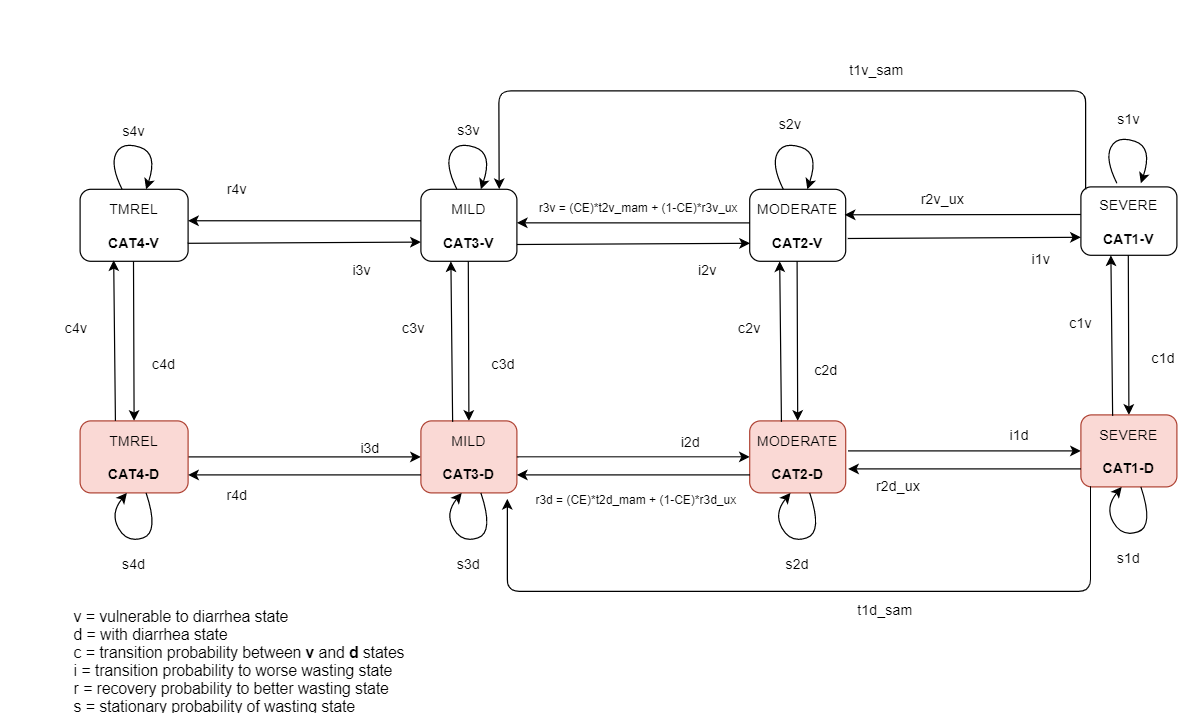

# WITHOUT MORTALITY 

In [12]:
#[{unknown:coefficient}, right hand side]
# NOTE: the system will solve eq(N-1) unknowns because among this set of equations from the transition matrix, there is 1 linearly dependent equation.

# # assuming equilibrium:
# 1)	p4v*s4v + p3v*r4v + p4d*c4v = p4v 
eq1 = [{s4v:p4v, r4v:p3v, c4v:p4d}, p4v]

# 2)	p4v*i3v + p3v*s3v +p2v*r3v + p1v*t1v_sam + p3d*c3v = p3v 
eq2 = [{i3v:p4v, s3v:p3v, r3v:p2v, t1v_sam:p1v, c3v:p3d}, p3v]

# 3)	p3v*i2v + p2v*s2v + p1v*r2v_ux + p2d*c2v = p2v 
eq3 = [{i2v:p3v, s2v:p2v, r2v_ux:p1v, c2v:p2d}, p2v]

# 4)	p2v*i1v + p1v*s1v + p1d*c1v = p1v 
eq4 = [{i1v:p2v, s1v:p1v, c1v:p1d}, p1v]

# 5)	p4v*c4d + p4d*s4d + p3d*r4d = p4d 
eq5 = [{c4d:p4v, s4d:p4d, r4d:p3d}, p4d]

#6) 	p3v*c3d + p4d*i3d + p3d*s3d + p2d*r3d + p1d*t1d_sam  = p3d 
eq6 = [{c3d:p3v, i3d:p4d, s3d:p3d, r3d:p2d, t1d_sam:p1d}, p3d]

#7) 	p2v*c2d + p3d*i2d + p2d*s2d + p1d*r2d_ux = p2d 
eq7 = [{c2d:p2v, i2d:p3d, s2d:p2d, r2d_ux:p1d}, p2d]

#8) 	p1v*c1d + p2d*i1d + p1d*s1d = p1d 
eq8 = [{c1d:p1v, i1d:p2d, s1d:p1d}, p1d]


# # rows sum to one:
# 9)	s4v + i3v + c4d = 1 
eq9 = [{s4v:1, i3v:1, c4d:1}, 1]

#10)	r4v + s3v + i2v + c3d = 1 
eq10 = [{r4v:1, s3v:1, i2v:1, c3d:1}, 1]

#11)	r3v + s2v + i1v + c2d = 1 
eq11 = [{r3v:1, s2v:1, i1v:1, c2d:1}, 1]

#12)	t1v_sam + r2v_ux + s1v + c1d = 1 
eq12 = [{t1v_sam:1, r2v_ux:1, s1v:1, c1d:1}, 1]

#13)	s4d + i3d + c4v = 1 
eq13 = [{s4d:1, i3d:1, c4v:1}, 1]

#14)	r4d + s3d + i2d + c3v = 1 
eq14 = [{r4d:1, s3d:1, i2d:1, c3v:1}, 1]

#15)	r3d + s2d + i1d + c2v = 1 
eq15 = [{r3d:1, s2d:1, i1d:1, c2v:1}, 1]

#16) c1v + t1d_sam + r2d_ux + s1d = 1 
eq16 = [{c1v:1, t1d_sam:1, r2d_ux:1, s1d:1}, 1]

#remission rates of DD
#17) c4v = 0.1 remission rate of dd
eq17 = [{c4v:1}, 0.1]

#18) c4v = 0.1 remission rate of dd
eq18 = [{c3v:1}, 0.1]

#19) c4v = 0.1 remission rate of dd
eq19 = [{c2v:1}, 0.1]

#20) c4v = 0.1 remission rate of dd
eq20 = [{c1v:1}, 0.1]

# #Wasting to diarrhea relative incidences from GBD RRs
# #21) c4d_val = 1-e**(-0.000823) 
# eq21 = [{c4d:1}, 0.00082]

# #22) c3d_val = 1-e**(-0.00132) 
# eq22 = [{c3d:1}, 0.00132]

# #23) c2d_val = 1-e**(-0.00288) 
# eq23 = [{c2d:1}, 0.00288]

# #24) c1d_val = 1-e**(-0.0104)
# eq24 = [{c1d:1}, 0.0103]


# need to also run a script that would assign risk of diarrhea within 1 time-step by wasting cat
# e = math.e
# c4d_val = 1-e**(-0.000823) 
# c3d_val = 1-e**(-0.00132) 
# c2d_val = 1-e**(-0.00288) 
# c1d_val = 1-e**(-0.0104) 

In [13]:
 1-e**(-0.0104)

0.010346106990904436

In [14]:
all_eqns = [eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9,eq10,eq11,eq12,eq13,eq14,eq15,eq16,eq17,eq18,eq19,eq20]#,eq21,eq22,eq23,eq24]

A1, x1, b1 = build_matrix(all_eqns, unknowns)

result = sym.solve(A1 * x1 - b1, x1)

/tmp/ipykernel_3636970/2715749290.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A[x][i] = terms[x]


## CHECKOUT WHAT WE WERE SOLVING

In [15]:
len(all_eqns)
#all_eqns

20

In [16]:
len(unknowns)

30

In [17]:
# matrix we're solving
pd.DataFrame(np.array(A1), columns = unknowns, index = [f'eq{i}' for i in range(1,len(all_eqns)+1)])

,s4v,s3v,s2v,s1v,s4d,s3d,s2d,s1d,i3v,i2v,...,t1v_sam,t1d_sam,c4v,c3v,c2v,c1v,c4d,c3d,c2d,c1d
eq1,p4v,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,p4d,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eq2,0.0,p3v,0.0,0.0,0.0,0.0,0.0,0.0,p4v,0.0,...,p1v,0.0,0.0,p3d,0.0,0.0,0.0,0.0,0.0,0.0
eq3,0.0,0.0,p2v,0.0,0.0,0.0,0.0,0.0,0.0,p3v,...,0.0,0.0,0.0,0.0,p2d,0.0,0.0,0.0,0.0,0.0
eq4,0.0,0.0,0.0,p1v,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,p1d,0.0,0.0,0.0,0.0
eq5,0.0,0.0,0.0,0.0,p4d,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,p4v,0.0,0.0,0.0
eq6,0.0,0.0,0.0,0.0,0.0,p3d,0.0,0.0,0.0,0.0,...,0.0,p1d,0.0,0.0,0.0,0.0,0.0,p3v,0.0,0.0
eq7,0.0,0.0,0.0,0.0,0.0,0.0,p2d,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,p2v,0.0
eq8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,p1d,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,p1v
eq9,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0
eq10,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0


In [18]:
# equals
np.array(x1)

array([[s4v],
       [s3v],
       [s2v],
       [s1v],
       [s4d],
       [s3d],
       [s2d],
       [s1d],
       [i3v],
       [i2v],
       [i1v],
       [i3d],
       [i2d],
       [i1d],
       [r4d],
       [r4v],
       [r3v],
       [r3d],
       [r2v_ux],
       [r2d_ux],
       [t1v_sam],
       [t1d_sam],
       [c4v],
       [c3v],
       [c2v],
       [c1v],
       [c4d],
       [c3d],
       [c2d],
       [c1d]], dtype=object)

In [19]:
unknowns

[s4v,
 s3v,
 s2v,
 s1v,
 s4d,
 s3d,
 s2d,
 s1d,
 i3v,
 i2v,
 i1v,
 i3d,
 i2d,
 i1d,
 r4d,
 r4v,
 r3v,
 r3d,
 r2v_ux,
 r2d_ux,
 t1v_sam,
 t1d_sam,
 c4v,
 c3v,
 c2v,
 c1v,
 c4d,
 c3d,
 c2d,
 c1d]

In [20]:
len(unknowns)

30

In [21]:
# solution to our system of eqns
result

{s4v: -p3v*r4v/p4v + 0.1*(-p4d + 10.0*p4v)/p4v,
 s3v: -c1d*p1v/p3v - c2d*p2v/p3v - c3d - p1v*t1v_sam/p3v - p2v*r3v/p3v - r4v + 0.1*(p1d + p2d + 10.0*p3v)/p3v,
 s2v: -c1d*p1v/p2v - c2d - p1v*r2v_ux/p2v - p1v*t1v_sam/p2v - r3v + 0.1*(p1d + 10.0*p2v)/p2v,
 s1v: -c1d - r2v_ux - t1v_sam + 1.0,
 s4d: c1d*p1v/p4d + c2d*p2v/p4d + c3d*p3v/p4d - p3d*r4d/p4d + 0.1*(-p1d - p2d - p3d + 9.0*p4d)/p4d,
 s3d: c1d*p1v/p3d + c2d*p2v/p3d - p1d*t1d_sam/p3d - p2d*r3d/p3d - r4d + 0.1*(-p1d - p2d + 9.0*p3d)/p3d,
 s2d: c1d*p1v/p2d - p1d*r2d_ux/p2d - p1d*t1d_sam/p2d - r3d + 0.1*(-p1d + 9.0*p2d)/p2d,
 s1d: -r2d_ux - t1d_sam + 0.9,
 i3v: c1d*p1v/p4v + c2d*p2v/p4v + c3d*p3v/p4v + p3v*r4v/p4v + 0.1*(-p1d - p2d - p3d)/p4v,
 i2v: c1d*p1v/p3v + c2d*p2v/p3v + p1v*t1v_sam/p3v + p2v*r3v/p3v + 0.1*(-p1d - p2d)/p3v,
 i1v: c1d*p1v/p2v - 0.1*p1d/p2v + p1v*r2v_ux/p2v + p1v*t1v_sam/p2v,
 i3d: -c1d*p1v/p4d - c2d*p2v/p4d - c3d*p3v/p4d + p3d*r4d/p4d + 0.1*(p1d + p2d + p3d)/p4d,
 i2d: -c1d*p1v/p3d - c2d*p2v/p3d + p1d*t1d_sam/p3d +

In [40]:
p4v_val = 0.8198
p3v_val = 0.1145
p2v_val = 0.0333
p1v_val = 0.0094
p4d_val = 0.0193
p3d_val = 0.0027
p2d_val = 0.0008
p1d_val = 0.0002

# # need to also run a script that would assign risk of diarrhea within 1 time-step by wasting cat
e = math.e
c4d_val = 1-e**(-0.000823) 
c3d_val = 1-e**(-0.00132) 
c2d_val = 1-e**(-0.00288) 
c1d_val = 1-e**(-0.0104) 

# #Remission of diarrhea within time-step, duration based 10-day remission rate
# c4v_val = 0.1
# c3v_val = 0.1
# c2v_val = 0.1
# c1v_val = 0.1
# wrote these up as eqs

In [41]:
subs = {
 i3v:  i3v,
 i2v:  i2v,
 i1v:  i1v,
 i3d:  i3d,
 i2d:  i2d,
 i1d:  i1d,
 r4v:  r4v,
 r3v:  r3v,
 r2v_ux:  r2v_ux,
 r4d:  r4d,
 r3d:  r3d,
 r2d_ux:  r2d_ux,
 t1v_sam:  t1v_sam,
 t1d_sam:  t1d_sam,
 s4v:  s4v,
 s3v:  s3v,
 s2v:  s2v,
 s1v:  s1v,
 s4d:  s4d,
 s3d:  s3d,
 s2d:  s2d,
 s1d:  s1d,
 c4d:  c4d_val,
 c3d:  c3d_val,
 c2d:  c2d_val,
 c1d:  c1d_val,
 p4v:  p4v_val ,
 p3v:  p3v_val ,
 p2v:  p2v_val ,
 p1v:  p1v_val ,
 p4d:  p4d_val ,
 p3d:  p3d_val ,
 p2d:  p2d_val ,
 p1d:  p1d_val
}

# # this is the dictionary of values we want to plug into our variables
# subs = {
#     s1: s1,
#     s2: s2,
#     s3: s3,
#     s4: s4,
#     r2: r2, #1/59,
#     r3: r3, #1/52, #this is actually r3 + t2
#     r4: r4, #0.05, #assumed almost 0
#     i1: i1, #0.0007, #james et al
#     i2: i2, #0.00708,
#     i3: i3, #0.014, #assumed almost 0
#     t1: t1, #1/48,#(1.5/365)*.43*.7, #
#     d1: d1_val,
#     d2: d2_val,
#     d3: d3_val,
#     d4: d4_val,
#     f1: f1_val,
#     f2: f2_val,
#     f3: f3_val,
#     f4: f4_val,
#     ap0: ap0_val,
#     ap1: ap1_val,
#     ap2: ap2_val,
#     ap3: ap4_val,
#     ap4: ap4_val
# }

In [42]:
def solution_set(more_subs = {}):
    df = pd.DataFrame({
        'var':result.keys(),
        'val':[result[i].subs(subs).subs(more_subs) for i in result.keys()]
    })
    return df

In [43]:
solution_set()

,var,val
0,i3v,-0.0406196633325201*r3v - 0.139668211758966*s3...
1,i2v,0.290829694323144*r3v + 0.0820960698689956*t1v...
2,i1v,0.282282282282282*r2v_ux + 0.282282282282282*t...
3,i3d,-0.0414507772020725*r3d - 0.139896373056995*s3...
4,i2d,0.296296296296296*r3d + 0.0740740740740741*t1d...
5,i1d,0.25*r2d_ux + 0.25*t1d_sam - 0.0965667571431271
6,r4d,-0.296296296296296*r3d - s3d - 0.0740740740740...
7,r4v,-0.290829694323144*r3v - s3v - 0.0820960698689...
8,s4v,0.0406196633325201*r3v + 0.139668211758966*s3v...
9,s2v,-0.282282282282282*r2v_ux - r3v - 0.2822822822...


In [44]:
solution_set({r3v:(1-0.488*.7)/63 + (.488*.7)/41.3, 
              r3d:(1-0.488*.7)/63 + (.488*.7)/41.3, 
              t1d_sam:(.488*.7)/48.3, 
              t1v_sam:(.488*.7)/48.3, 
              r2v_ux:(1-0.488*.7)/52, 
              r2d_ux:(1-0.488*.7)/52,
              r4d: 0.001,
              r4v: 0.001})

,var,val
0,i3v,0.138497288245345 - 0.139668211758966*s3v
1,i2v,0.00683792605155534
2,i1v,0.00789048128147907
3,i3d,0.131221120813297 - 0.139896373056995*s3d
4,i2d,-0.0283805035592560
5,i1d,-0.0916332565857135
6,r4d,0.928380503559256 - s3d
7,r4v,0.991842944765243 - s3v
8,s4v,0.139668211758966*s3v + 0.859116836819199
9,s2v,0.970511681848602


# END HERE
# -------------------------------------------------------------------------------------------------------------

In [ ]:
solution_set({r3:(0.512/63) + (.488/41.3), t1:.488/48.3, r2:.512/50.5, r4:.001})

In [ ]:
def toggle_solution_set(r3_val, t1_val, r2_val, r4_val):
    print(solution_set({r3:r3_val, t1:t1_val, r2:r2_val, r4:r4_val}))

In [ ]:
toggle_solution_set(r3_val = 1/52, t1_val = 1/48, r2_val = 1/59, r4_val = .001)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [ ]:
y = interactive(toggle_solution_set,
                r3_val = (1/80,1/30,0.00208), t1_val = (1/80,1/30,0.00208),
                r2_val = (1/80,1/30,0.00208), r4_val = (.0001,.01,0.00099),
                readout_format='.9f'
               )

In [ ]:
# huh need to fix slider display precision
display(y)